In [1]:
import itertools
import pandas as pd
from matplotlib import pyplot as plt

import statsmodels.api as sm 
from statsmodels.tsa import stattools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings

In [2]:
# Define data path, sheets to select, index names, filter condition and selection data
data_path = './data/ibm-common-stock-closing-prices.csv'

index_name = 'Date'
filter_on = None                                       # Eg. ('Category', 'Supplies')
filter_sheet = None                                    # Eg. 'Orders'
filter_column = 'IBM common stock closing prices'

In [3]:
# Read the data from the file into dataframe
extension = data_path.split('.')[1]
df = None
if extension == 'csv':
    df = pd.read_csv(data_path)
elif extension in ['xls', 'xlsx']:
    xls = pd.ExcelFile(data_path)
    sheet_names = xls.sheet_names
    df = xls.parse(filter_sheet, header = 0)
    
assert df is not None, 'Cound not load the file'

headers = df.columns.values
print('Columns are: ', ', '.join(headers), end = '\n')
if filter_on is not None:
    categories = df[filter_on[0]].unique()
    print('Sub Categories are', ', '.join(categories))

print(df.head(3))
print('Total data size = ', len(df))

Columns are:  Date, IBM common stock closing prices
         Date  IBM common stock closing prices
0  1962-01-02                           572.00
1  1962-01-03                           577.00
2  1962-01-04                           571.25
Total data size =  1008


In [4]:
# Filter a time series data indexed by the date
cond_index = [True] * len(df) if filter_on is None else df[filter_on[0]] == filter_on[1]
data = df.loc[cond_index, [index_name, filter_column]].reset_index()
data = data.groupby(index_name)[filter_column].sum().reset_index()
data = data.set_index(index_name)
data.head(3)

,IBM common stock closing prices
Date,
1962-01-02,572.00
1962-01-03,577.00
1962-01-04,571.25


In [5]:
# Data preprocessing stage
# Replace null values with the mean of consecutive points centered on null values
data.fillna(data.rolling(window = 3, center = True, min_periods = 1).mean(), inplace = True)
data.index = pd.to_datetime(data.index)

In [6]:
monthwise_data = data[filter_column].resample('MS').mean().reset_index()
monthwise_data = monthwise_data.set_index(index_name)
monthwise_data.head(3)
y = monthwise_data[filter_column]

start_date = min(y.index)
end_date = max(y.index)

split_date = pd.to_datetime('{year}-{month}-{date}'.format(year = end_date.year - 1, month = end_date.month, date = end_date.day))
print('Test data is from ', split_date.strftime('%Y-%b-%d'), 'to', end_date.strftime('%Y-%b-%d'))

Test data is from  1964-Dec-01 to 1965-Dec-01


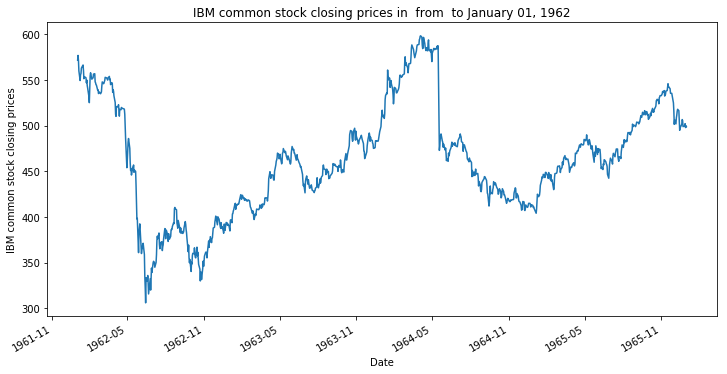

In [7]:
subcategory = ' on ' + filter_on[1] if filter_on is not None else ''
sheetinfo = ' in ' + filter_sheet if filter_sheet is not None else ''
plt_title = '{} in {} from {} to {}'.format(filter_column,
                                            subcategory,
                                            sheetinfo, 
                                            start_date.strftime('%B %d, %Y'), 
                                            end_date.strftime('%B %d, %Y'))

fig = plt.figure(figsize = (12, 6))
plt.title(plt_title)

data[filter_column].plot()

plt.xlabel(data.index.name)
plt.ylabel(data.columns.values[0])
plt.show()

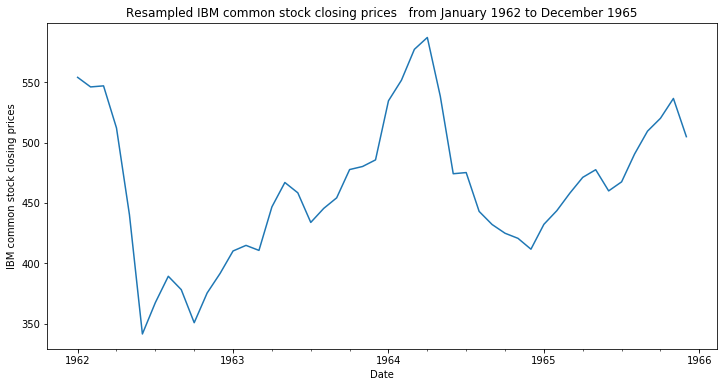

In [8]:
subcategory = (' on ' + filter_on[1]) if filter_on is not None else ''
sheetinfo = (' in ' + filter_sheet) if filter_sheet is not None else ''
plt_title = 'Resampled {} {} {} from {} to {}'.format(filter_column,
                                                      subcategory, 
                                                      sheetinfo, 
                                                      start_date.strftime('%B %Y'), 
                                                      end_date.strftime('%B %Y'))
plt.figure(figsize = (12, 6))

plt.xlabel(y.index.name)
plt.ylabel(y.name)

y.plot(title = plt_title)
plt.show()

# ARIMA
-------------------------------------------------------
## AR
An AR model tries to predict the next timestep value based on the lagged values at previous timesteps. <br>
It is essentially multiple regression task, however, the weight terms or coefficients measure the impact the prior measument have on current one.<br>
## MA
A moving average model is basically an AR but with the lagged values of noise or error terms regressing the current observation.
<br>It measures how the measurement error terms (difference between the prediction and current value) weight in to define current measurement.
## I
The differenced series is integrated into AR and MA models with p, & q coefficients, respectively.

### Parameters choice:
<ul>
    <li>
        <b>p</b> denotes number of coefficients or lagged values of data points to consider for current regression. <br>
We can use ACF plot to indetify the cut-off lag or order of AR process, (e.g. if cut-off is on lag of 3, then most likely the order is 2). <br>
    </li>
    <li>
        <b>q</b> denotes number of coefficients or lagged values of errors to consider for current regression. <br>
        We can use PACF plot to identify the cut-off lag or order of MA process, (e.g. if cut-off is on lag of 2, then most likely the order is 1). <br>
    </li>
    <li>
        <b>d</b> denotes the differencing to be used for trend removal, as recommended for stationarising series for ARIMA. <br>
    </li>
</ul>
    

### Note:
<ol>
    <li>
        A trend can be eliminated by fitting a line and differencing (linear regression), or moving average differencing, or lagged differencing techniques. (Constant mean)
    </li>
    <li>
        We can log transform the dataset to make the values more linear if the data has non-uniform variance. (Constant variance)
    </li>
    <li>
        A seasonality can be eliminated by seasonal differencing (say 12 month or 6 month season, based on knowledge of data). (Constant covariance)
    </li>
</ol>    
<ul> 
    <li>
        Augmented Dickey-Fuller Test (ADF) tests whether the coefficient term for two subsequent timesteps is significantly different from 1, (a value close to 1 means the data has roots signifying underlying trends to it). <br>
        Equivalently, the difference of coefficient with 1 should not be close to null value for the data to be trend-stationary.
    </li>
    <li>
        If both ACF and PACF decrease gradually, we need to first stationarize the series.    
    </li>
    <li>
        Seasonality can be incorporated within the ARIMA process given the data is trend-stationary.
    </li>
    <li>
        Partial autocorrelation ignores the effects of intermediate timestep values while computing correlation (i.e. t - 2 correlation affects between successive points that are t timesteps apart are removed).<br>
        Whereas ACF simply finds the correlation coefficient between the two data-points.
    </li>
</ul>

In [9]:
adf_result = stattools.adfuller(y, autolag = 'AIC')
print('ADF statistic: ', adf_result[0])
print('p-val of ADF test: ', adf_result[1])
print('Critical values:')
for key, val in adf_result[4].items():
    print('\t{:s}: {:.3f}'.format(key, val))
    
# If ADF statistic is less than the critical value at 1% confidence,
# we can reject the null hypothesis at 1% confidence interval
# So our time series is said to be stationary (constant mean, variance and auto-correlation)

ADF statistic:  -2.88554239441401
p-val of ADF test:  0.04705523585551498
Critical values:
	1%: -3.581
	5%: -2.927
	10%: -2.602


<Figure size 864x1440 with 0 Axes>

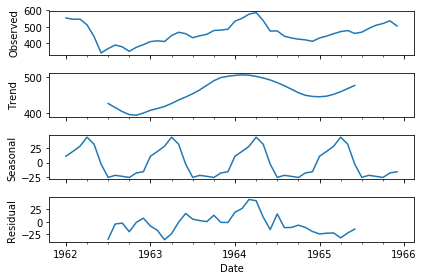

In [10]:
decomposition = sm.tsa.seasonal_decompose(y, model = 'additive')
plt.figure(figsize = (12, 20))
fig = decomposition.plot()
plt.show()

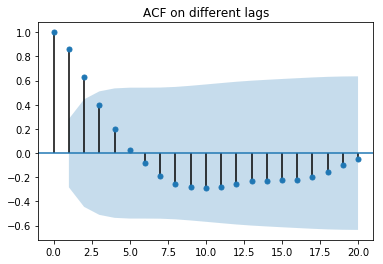

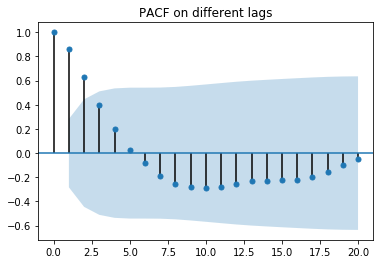

In [11]:
# Plot autocorrelation, partial autocorrelation and confidence interval 

plot_acf(y, lags = 20, title = 'ACF on different lags')
plot_acf(y, lags = 20, title = 'PACF on different lags')
plt.show()

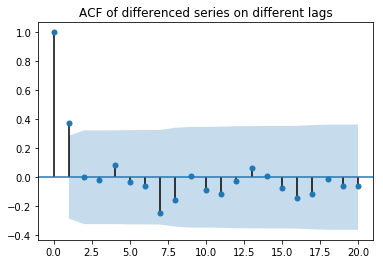

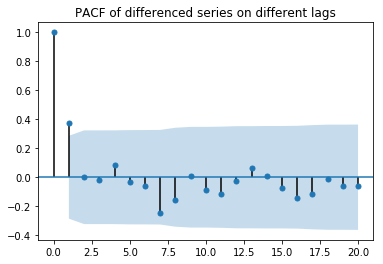

In [12]:
# Since the curves show a gradual change, we can try differencing the series (d) with lag 1 to detrend it
diff_y = y.diff(1)[1:]            # Get a difference series at lag 1

plot_acf(diff_y, lags = 20, title = 'ACF of differenced series on different lags')
plot_acf(diff_y, lags = 20, title = 'PACF of differenced series on different lags')
plt.show()

# Both series cut off after 1st lag, so most likely p and q are 1, and there's no evident seasonality.
# We can compare scores of different configurations p, d , q values to determine optimal values of parameters.

In [13]:
# p is the number of regression coefficients
# d is the differencing to be applied to the series prior to AR and MA modeling
# q is the number of moving average coefficients
# AIC is the Akaike’s Information Criteria (similar to the KL divergence), the minimum the better.
# In SARIMAX, S denotes Seasonal parameter, and X the explanatory variables present in the model.

aic_list = []
p = range(3); q = range(3); d = range(3); s = range(0, 13, 6)
params = itertools.product(p, d, q, s)
for seasonal_param in params:
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            mod = sm.tsa.statespace.SARIMAX(y,
                                            seasonal_order = seasonal_param,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)
            results = mod.fit(maxiter = 200)
        aic_list.append((seasonal_param, results.aic))
        # print('ARIMA {} - AIC: {}'.format(seasonal_param, results.aic))
    except:
        continue
seasonal_param, value = min(aic_list, key = lambda x: x[1])
param = seasonal_param[:-1]
print('Minimum AIC is {:.2f} with parametes {}'.format(value, seasonal_param))

Minimum AIC is 100.62 with parametes (2, 1, 0, 12)


/home/ashish/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9645      0.171      5.628      0.000       0.629       1.300
ar.S.L12      -0.9207      0.358     -2.570      0.010      -1.623      -0.219
ar.S.L24      -0.1584      0.262     -0.604      0.546      -0.672       0.356
sigma2       265.6417    207.122      1.283      0.200    -140.311     671.594


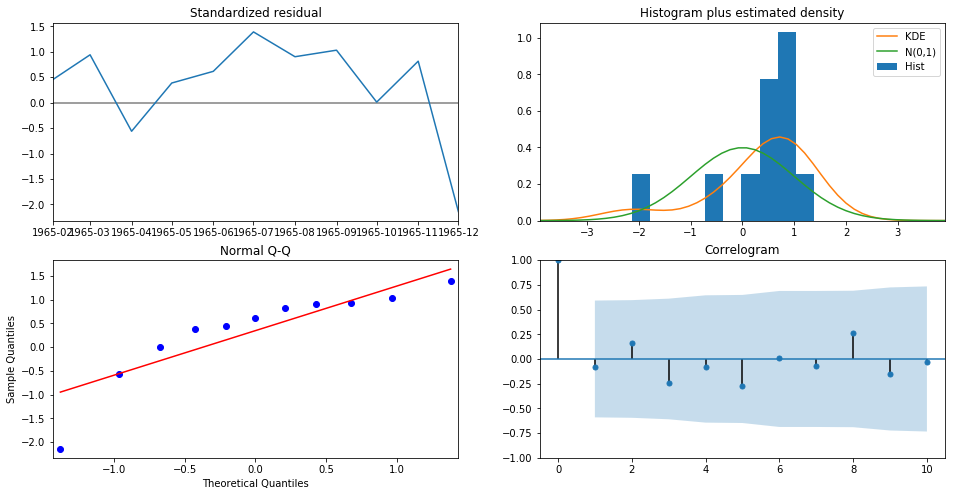

In [14]:
# Creating SARIMAX model with the optimal parametes
mod = sm.tsa.statespace.SARIMAX(y,
                                seasonal_order = seasonal_param,
                                enforce_stationarity = False,
                                enforce_invertibility = False)
results = mod.fit(max_iter = 200)

print(results.summary().tables[1])
results.plot_diagnostics(figsize = (16, 8))
plt.show()

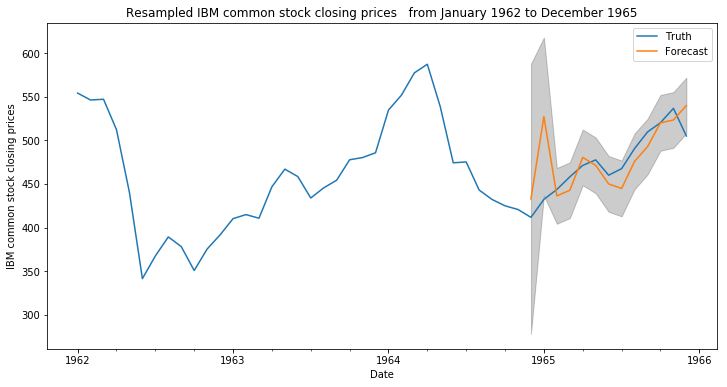

In [15]:
# Generating predictions
pred = results.get_prediction(start = split_date, end = end_date, dynamic = False)
pred_conf_int = pred.conf_int()

ax = y.plot(title = plt_title, label = 'Truth')
pred.predicted_mean.plot(ax = ax, label = 'Forecast', alpha = 1., figsize = (12, 6))

ax.fill_between(pred_conf_int.index.values,
                pred_conf_int.iloc[:, 0],
                pred_conf_int.iloc[:, 1],
                color = 'k',
                alpha = .2)

subcategory = (' on ' + filter_on[1]) if filter_on is not None else ''
sheetinfo = (' in ' + filter_sheet) if filter_sheet is not None else ''

plt_title = '{} {} {} from {} to {}'.format(filter_column,
                                            subcategory,
                                            sheetinfo,
                                            start_date.strftime('%B %Y'), 
                                            end_date.strftime('%B %Y'))
plt.xlabel(y.index.name)
plt.ylabel(y.name)
plt.legend()
plt.show()

In [16]:
observations = list(y[split_date:])
predictions = pred.predicted_mean.values

mse = sum([(y_true - y_pred) ** 2 for y_true, y_pred in zip(observations, predictions)]) / len(observations) 
print('Mean squared error = {:.2f}'.format(mse))

Mean squared error = 952.11
